## DIGIT RECOGNIZER

### Importing the libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib inline will make your plot outputs appear and be stored within the notebook, instead of opening the plot in a new window.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import confusion_matrix
import itertools
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns


### Load Train Data and Test Data

In [54]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()
#train.shape tells gives as a tuple of (rows,columns)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
x_train = train.iloc[:, 1:].values
y_train = train.iloc[:, :1].values
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Currently x_train consists of 42000 1D Arrays with 784 elements(pixels) in each of them.  
These represent the 42000 images present in the training set

#### Data Normalization

Grayscale normalization is performed to reduce the effect of the illumination's differences.  
Also, the CNN converges faster on data in the range [0,1] than in the range [0,255]

In [57]:
x_train = x_train/255.0
test = test/255.0
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Data Visualization

subplot divides a plot into sub-plots.  
It expects a three numbers as arguments.  
The first number being the number of rows, the second number being the number of columns, and the third being the plot position.  
The plot position starts from 1 and 1 means the first position in the subplot.  
Here we have done reshape because each array element(x_train[i]) consists of 784 elements.  
This has to be expressed in the dimensions of 28*28 to be displayed as an image.

c:\Users\Shreya\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


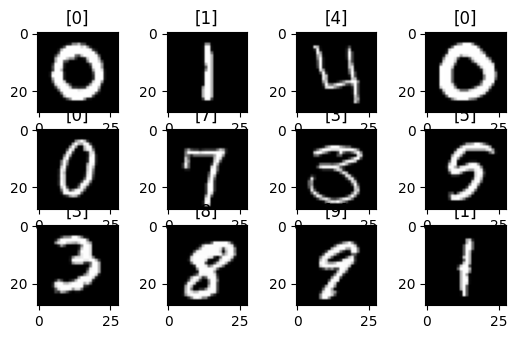

In [58]:
for i in range(1,13):
    plt.subplot(4,4,i)
    plt.imshow(x_train[i].reshape(28,28), cmap = plt.get_cmap('gray'))
    plt.title(y_train[i])

### Reshaping the data

In keras the input layer is not a layer, but a tensor. This means that it is the shape you give as the input to neural network.  
If you have 30 images of 50 x 50 pixels in RGB, ths shape of the input data is (30,50,50,30).  
The total number of images are 75000.  
The number of channels are 3 for RGB and 1 for gray.

In [59]:
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_train.shape
#Note here that the x_train.shape[0] = 42000, as it has 42000 rows and only 1 column.  
#This is the same as x_train = x_train.reshape(42000,28,28,1) 

(42000, 28, 28, 1)

In [60]:
test = test.values.reshape(test.shape[0],28,28,1)
test.shape

(28000, 28, 28, 1)

### One Hot Encoding of Labels

One-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension.  In this case, the nth digit will be represented as a vector which is 1 in the nth dimension.  
For exmple 4 would be [0,0,0,0,1,0,0,0,0,0]

In [61]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train,num_classes=10)
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### Splitting the data into training set and test set.

In [62]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size = 0.1,random_state = 2)
print("x_train shape: ",x_train.shape)
print("x_test.shape: ",x_test.shape)
print("y_train.shape: ",y_train.shape)
print("y_test.shape",y_test.shape)

x_train shape:  (37800, 28, 28, 1)
x_test.shape:  (4200, 28, 28, 1)
y_train.shape:  (37800, 10)
y_test.shape (4200, 10)


### Designing Neural Network Architecture

In [63]:
from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D

In [64]:
#fixing random seed for reproducibility.
seed = 43
np.random.seed(seed)

We can create a Keras model using Sequential.  
The Sequential model is a linear stack of layers.  
A Sequential model can be created by passing a list of layer instances to the Sequential constructor or you can simply add layers via the .add() method.  
Keras Conv2D is a 2D Convolutional Layer.  
Filters mean kernels.  
A Kernel is a matrix that moves over the input data, performs dot-product over the sub-region of the input data and gets the output as a matrix of dot products. It is a filter used to extract features from the images.  
Here the first Conv2D layer has 8 filters (kernels) with a 5X5 dimension the second Conv2D layers has 16 filters (kernels) with a dimension of 3X3.  
Padding means adding zeroes around the borders in order to reduce dimensionality.  
The relu (Rectified Linear Unit) activation function is applied here.  
Input data may have some unwanted data, usually called noise, and Dropout will try to remove the noise data and thus prevent the model from over-fitting.  

In [65]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'Same', activation = 'relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

#Dense layer is the regular deeply connected neural network layer.
model.add(Dense(10, activation="softmax"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

#### Optimizer

Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses.

In [66]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

c:\Users\Shreya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Compile model - Categorical Cross Entropy

Categorical cross-entropy is used when true labels are one-hot encoded.  
Cross-entropy loss is the most important cost function. It is used to optimize classification models.  

In [67]:
model.compile(optimizer = optimizer, loss="categorical_crossentropy",metrics=["accuracy"])

### Epochs and Batch Size

If you have a dataset of 10 examples, batch size of 2 and number of epochs is 3.  
Therefore in each epoch, you have 5 batches (2 examples each). Per epoch you have 5 iterations.  

In [68]:
epochs = 10
batch_size = 250

### Data (Image) Augmentation

Data Augmentation is done to prevent overfitting.  
Consists of transforming the images of the training set, so that the the CNN doesn't overlearn on the existing images.  
By applying these transformations such as rotating or rescaling we will get slightly altered versions of the original images.  

In [69]:
datagen = ImageDataGenerator(featurewise_center=False,  #set input mean to 0 over the dataset
                             samplewise_center=False,   #set each sample mean to 0                                                         
                             featurewise_std_normalization=False,    #divide inputs by std of the dataset
                             samplewise_std_normalization=False,     #divide each input by its std
                             zca_whitening=False,        #dimension reduction
                             rotation_range=5,           #randomly rotate images in the range 5 degreees    
                             zoom_range = 0.1,           #randomly zoom image 10%
                             width_shift_range = 0.1,    #randomly shift images horizontally 10%
                             height_shift_range = 0.1,   #randomly shift images vertically 10%
                             horizontal_flip=False,      #randomly flip images
                             vertical_flip = False)      #randomly flip images
datagen.fit(x_train)


### Fit the model

In [75]:
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs, validation_data=(x_test,y_test),steps_per_epoch=x_train.shape[0]//batch_size)

Epoch 1/10


C:\Users\Shreya\AppData\Local\Temp\ipykernel_62324\3602415275.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs, validation_data=(x_test,y_test),steps_per_epoch=x_train.shape[0]//batch_size)


151/151 [==============================] - 14s 94ms/step - loss: 1.4266 - accuracy: 0.4397 - val_loss: 0.9426 - val_accuracy: 0.8836
Epoch 2/10
151/151 [==============================] - 13s 89ms/step - loss: 1.4160 - accuracy: 0.4399 - val_loss: 0.9028 - val_accuracy: 0.8676
Epoch 3/10
151/151 [==============================] - 13s 88ms/step - loss: 1.4041 - accuracy: 0.4428 - val_loss: 0.8708 - val_accuracy: 0.8767
Epoch 4/10
151/151 [==============================] - 14s 95ms/step - loss: 1.3870 - accuracy: 0.4512 - val_loss: 0.8412 - val_accuracy: 0.8721
Epoch 5/10
151/151 [==============================] - 15s 96ms/step - loss: 1.3698 - accuracy: 0.4571 - val_loss: 0.8105 - val_accuracy: 0.8776
Epoch 6/10
151/151 [==============================] - 14s 94ms/step - loss: 1.3586 - accuracy: 0.4577 - val_loss: 0.7880 - val_accuracy: 0.8762
Epoch 7/10
151/151 [==============================] - 13s 84ms/step - loss: 1.3593 - accuracy: 0.4571 - val_loss: 0.7650 - val_accuracy: 0.8814
Epo

### Evaluate the model

Test Loss visualization.  
Confusion matrix.  

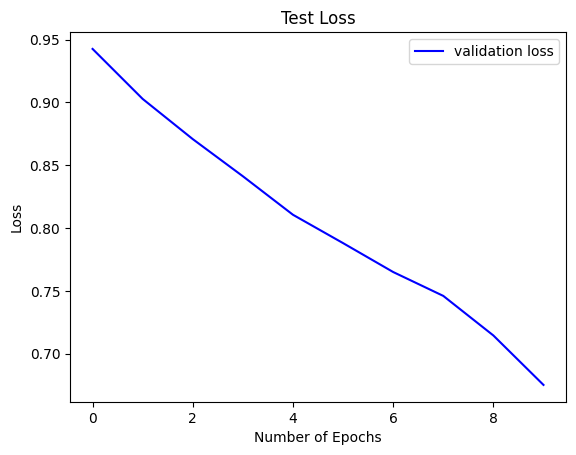

In [77]:
plt.plot(history.history['val_loss'], color='b',label='validation loss')
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Confusion Matrix

132/132 [==============================] - 1s 5ms/step


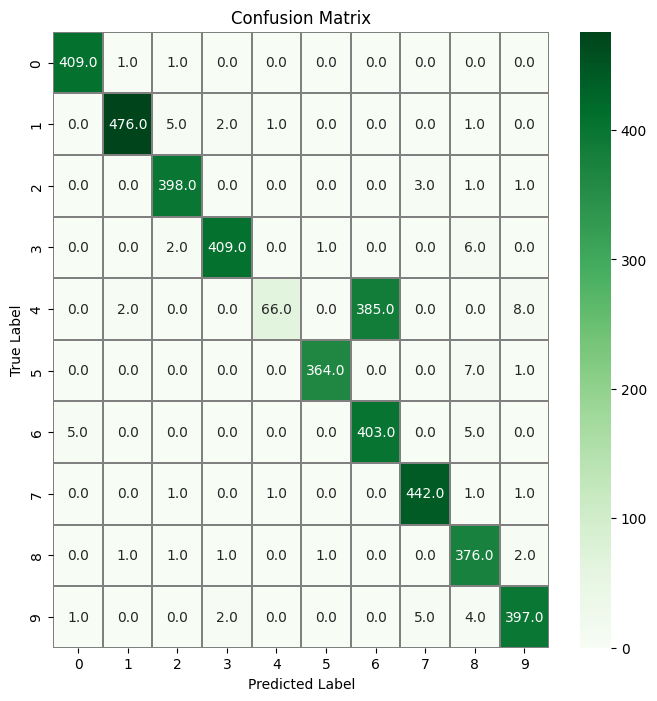

In [78]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test,axis=1)
confusion_mtx= confusion_matrix(y_true, y_pred_classes)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray",fmt='.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [79]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis = 1)
results = pd.Series(predictions, name="Label")


132/132 [==============================] - 1s 5ms/step


In [80]:
final_file=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),"Label": predictions})
final_file.to_csv("cnn.csv",index=False,header=True)